# Lab 4: Simulation, Sampling, and Bootstrapping

## Due Thursday, May 9th at 11:59PM

Welcome to Lab 4! This covers the topics listed below. Click the links below to read about these topics in the textbook, and don't forget you can always refer to the lecture slide content quickly by clicking the pencil emoji next to each lecture on the [course website](http://dsc10.com)

- Simulation (see [CIT 9.3](https://inferentialthinking.com/chapters/09/3/Simulation.html))
- Sampling (see [CIT 10](https://inferentialthinking.com/chapters/10/Sampling_and_Empirical_Distributions.html))
- Bootstrapping (see [CIT 13](https://inferentialthinking.com/chapters/13/Estimation.html))

You should complete this entire lab so that all tests pass and submit it to Gradescope by 11:59PM on the due date.

In [1]:
import numpy as np
import babypandas as bpd
import math

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

# import otter
# grader = otter.Notebook()

from IPython.display import YouTubeVideo, IFrame

def show_bootstrapping_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vS_iYHJYXSVMMZ-YQVFwMEFR6EFN3FDSAvaMyUm-YJfLQgRMTHm3vI-wWJJ5999eFJq70nWp2hyItZg/embed?start=false&loop=false&delayms=3000&rm=minimal"
    width = 600
    height = 320
    display(IFrame(src, width, height))

## 1. Dungeons and Dragons 🐉

In the fantasy role-playing game Dungeons & Dragons, each player takes on the role of a certain character.

To perform an action, a player rolls a 20-sided die, adds a "modifier" number to the roll, and compares the total to a threshold for success.  The value of the modifier depends on the player's character's competence in performing the action.

Throughout this question, we'll work with the following concrete example. Suppose Ashley's character, a barbarian warrior named Wulfgar, is trying to knock down a heavy door.  Ashley rolls a 20-sided die, adds a modifier of 9 to the result (because her character is good at knocking down doors), and succeeds in knocking down the door if the total is at least 16.

**Question 1.1.** Write code that simulates this procedure.  Compute three values: 
- the result of Ashley's 20-sided die roll (`roll_result`), 
- the result of her roll plus Wulfgar's modifier of 9 (`modified_result`), and 
- a Boolean value indicating whether the action succeeded (`action_succeeded`).  

**Do not fill in any of the results manually**; the entire simulation should happen in code.

***Hint:*** A roll of a 20-sided die is a number chosen uniformly from the array `np.array([1, 2, 3, 4, ..., 20])`. You can store these possibilities in `possible_rolls`.  So a roll of a 20-sided die *plus 9* is a number chosen uniformly from that array, plus 9.

In [2]:
possible_rolls = np.arange(1, 21)
possible_rolls

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [3]:
modifier = 9

In [4]:
roll_result = np.random.choice(possible_rolls)
modified_result = roll_result + modifier
action_succeeded = (modified_result >= 16)

# The next line just prints out your results in a nice way
# once you're done.  You can delete it if you want.
print("On a modified roll of {:d}, Ashley's action {}.".format(modified_result, "succeeded" if action_succeeded else "failed"))

On a modified roll of 10, Ashley's action failed.


In [5]:
roll_result

1

**Question 1.2.** Let's repeat the above simulation ten times. Below, assign `ten_reps` to an array of Booleans, where each element corresponds to whether a single simulation was successful. Then, determine the fraction of those simulations that succeeded, and assign your answer to `rough_success_chance`.

***Note:*** Do **not** use a `for`-loop here! Instead, call `np.random.choice` with multiple arguments (the second of which is the number of times you want to roll the die). The result will be an array. Remember that, for example, `arr + 1` adds the number 1 to every element in the array `arr`.

In [6]:
ten_reps = np.random.choice(((possible_rolls + modifier)>=16), 10)
ten_reps

array([ True,  True,  True,  True, False, False, False,  True, False,
        True])

In [7]:
rough_success_chance = np.count_nonzero(ten_reps)/len(ten_reps)
rough_success_chance

0.6

**Question 1.3.** What is the theoretical probability of Wulfgar successfully knocking down the door when rolling a 20-sided die with a modifier of 9 and success threshold of 16? This is a math question, not a programming question.

In [8]:
### The result above means that, out of a maximum of 29 "points", the result must be greater or equal to 16. 
### By subtracting the 9, as it is a guarantee, that would be the same as getting a result of atleast 7 in a throw of 20, 
### which is 1 - 6/20 (getting atleast a 7 out of 20)

In [9]:
theoretical_probability = 1 - (6/20)
theoretical_probability

0.7

**Question 1.4.** Let's try and put some of your work from Question 1.2 into a function. Below, complete the implementation of the function `simulate_modified_rolls`.  It should take no arguments, and it should return an array of ten numbers.  Each of the numbers should be the modified roll from one simulation.  **Then**, call your function once to compute an array of ten simulated modified rolls.  Name that array `modified_rolls`.

Again, like in Question 1.2, there should be no need to use a `for`-loop.

In [10]:
modifier = 9 # Don't change this!
num_rolls = 10 # Don't change this!

def simulate_modified_rolls():
    """Returns an array of 10 simulated modified die rolls."""
    keeps_result = np.array([])
    result = np.random.choice((possible_rolls + modifier), num_rolls)
    keeps_result = np.append(keeps_result, result)
    return keeps_result
        
    
modified_rolls = simulate_modified_rolls()
modified_rolls

array([10., 28., 13., 12., 12., 25., 12., 13., 28., 22.])

Now, let's pretend we **don't know** that Wulfgar has a modifier of 9 for this action. Instead, we observe the modified roll (that is, the die roll plus the modifier) from ten of Wulfgar's attempts to knock down doors. We would like to **estimate** Wulfgar's modifier using just the ten numbers in the array `modified_rolls`, and nothing else.

One straightforward way to do this involves looking at the smallest overall modified roll. Remember, the smallest number on a 20-sided die is 1, and the smallest possible modifier is 0.
- If we see that the smallest modified roll was 1, we know that the character's modifier must be 0. 
- If we see that the smallest modified roll is something larger than 1 – say, 13 – we can't say for certain what the character's modifier is. In this case, **we'll guess that at some point, the player rolled a 1**, and that their character's modifier is **13 - 1 = 12**. 
    - This works because, if we see enough modified rolls, one of them will have occurred when the player rolled a 1.

**Question 1.5.** Using this method, estimate `modifier` from `modified_rolls` and name that estimate `min_based_estimate`. If you're not sure what to do, read the previous paragraph again carefully.

In [11]:
# if min(modified_rolls) == 1:
#     min_based_estimate = 0
# else: 
#     min_based_estimate = min(modified_rolls-1)

### The if and else statements above are unnecessary: if min(modified_rolls) == 1, 
###min_based_estimate = min(modified_rolls-1) is already 0

min_based_estimate = min(modified_rolls-1)

#min_based_estimate = min()
min_based_estimate

9.0

Another way to estimate the modifier involves the mean of `modified_rolls`. 
- If a character's modifier is zero, then the mean of many of their modified rolls will be close to the mean of 1, 2, ..., 20, which is 10.5. 
- If their modifier is $m$, then the mean of their modified rolls will be close to the mean of $1 + m$, $2 + m$, ..., $20 + m$,
which is 10.5 + $m$. 
- Since we can calculate the mean of the modified rolls, we can use this to estimate $m$.

**Question 1.6.** Write a function named `estimate_modifier` that computes an estimate of the modifier using this method.  It should take an array of modified rolls (like the array `modified_rolls`) as its argument and return an estimate of `modifier` based on the mean of those numbers.

***Note:*** It's okay if your `mean_based_estimate` is not an integer!

In [12]:
modified_rolls

array([10., 28., 13., 12., 12., 25., 12., 13., 28., 22.])

In [13]:
np.mean(modified_rolls)

17.5

In [14]:
def estimate_modifier(nums):
    """Estimate the roll modifier based on observed modified rolls in the array nums."""
    get_mean = np.mean(nums)
    estimated_modifier = get_mean - 10.5 ### if the array is of 1 to 20, this will give 0. Otherwise it will give m
    return estimated_modifier

# Here is an example call to your function.  It computes an estimate
# of the modifier from our ten modified rolls.
mean_based_estimate = estimate_modifier(modified_rolls)
mean_based_estimate

7.0

Remember, the actual modifier was 9. Which was a better estimate, the `min_based_estimate` or the `mean_based_estimate`? Run the cell below to compare the different estimates to the actual modifier.

In [15]:
print("Actual modifier:", modifier)
print("Min-based estimate:", min_based_estimate)
print("Mean-based estimate:", mean_based_estimate)

Actual modifier: 9
Min-based estimate: 9.0
Mean-based estimate: 7.0


Which estimation strategy do you think is better in general? Does the better estimation strategy change as the number of observations grows? Does the value of the actual modifier matter? Feel free to explore these questions or answer some questions of your own!

In [16]:
# Play around, it's good practice!
modified_rolls2 = simulate_modified_rolls()
modified_rolls2

array([27., 16., 23., 17., 29., 11., 13., 20., 22., 28.])

In [17]:
min_based_estimate2 = min(modified_rolls2-1)
min_based_estimate2

10.0

In [18]:
mean_based_estimate2 = estimate_modifier(modified_rolls2)
mean_based_estimate2

10.100000000000001

By increasing the number of observations, we can imagine that the min-based estimate will be better than the mean-based estimate. This is because we can almost guarantee that we will have a "minimum" result of 1+m when throwing more times. Meanwhile, increasing the number of observations may give us many results very far from the minimum, closer to 20+m, and they might be of a larger number than those of near 1+m values. Because of this, the mean would be far from m. 

## 2. Allied Intelligence Preliminaries 🧠

Now that we've had some fun with Dungeons and Dragons, we'll focus on a more serious problem throughout the rest of this lab.

In World War II, the Allies (led by the US, the UK, and the Soviet Union) wanted to know how many military tanks the Germans had produced. However, they didn't get to see every single tank produced by the Germans – rather, all they saw was a random **sample** of tanks, and the wanted to use this sample to estimate the total number of tanks produced by the Germans. This problem, known as the [German tank problem](https://en.wikipedia.org/wiki/German_tank_problem), is a famous application of statistical estimation in a real-world scenario.

To frame the problem more precisely, consider that tanks were given serial numbers ranging from 1 to `N`, where `N` was the total number of tanks produced. The Allies were trying to estimate `N`, a **population parameter**, using the serial numbers of the tanks in their sample. We will assume that the Allies' sample is a simple random sample of the population (drawn without replacement).

<br>

<center><img src='tank.jpg' width=400></center>

<br>


In this lab, given **just** a random sample of serial numbers, we'll estimate `N`, and then we'll use simulation to find out how accurate our estimate likely is, without ever looking at the whole population. This is an example of **statistical inference** – inferring something about a population using just the information in a sample.

**Question 2.1.** Is `N` a population parameter or a statistic?  If we compute a number using our random sample that's an estimate of `N`, is that a population parameter or a statistic?  Assign either 1, 2, 3, or 4 to the variable `q2_1` below. 
1. `N` is a population parameter.  An estimate of `N` from our random sample is a population parameter.
2. `N` is a population parameter.  An estimate of `N` from our random sample is a statistic.
3. `N` is a statistic.  An estimate of `N` from our random sample is a population parameter.
4. `N` is a statistic.  An estimate of `N` from our random sample is a statistic.

In [19]:
q2_1 = 2

To make the situation realistic, we're going to hide the true number of tanks from you.  You'll have access only to this random sample:

In [20]:
observations = bpd.read_csv("serial_numbers.csv")
num_observations = observations.shape[0]
observations

,serial_number
0,47
1,42
2,57
3,79
4,26
...,...
12,67
13,108
14,84
15,50


In [21]:
observations.sort_values(by='serial_number', ascending=False)

,serial_number
9,135
13,108
14,84
8,83
3,79
...,...
10,41
6,36
4,26
5,23


**Question 2.2.** Complete the implementation of the function `plot_serial_numbers`, which draws a histogram of any DataFrame of serial numbers.  It should take one argument, a DataFrame `df` with a single column column called `'serial_number'` (like `observations`).  It should plot a histogram of the values in the `'serial_number'` column **using bins of width 1** ranging from **1 to 200 (inclusive)** but return nothing.  Then, call that function to make a histogram of `observations`.

In [22]:
def plot_serial_numbers(df):
    bins = np.arange(1, 200, 1)
    df.plot(kind='hist', y='serial_number', bins=bins, density=True, ec='w');

# Call your function.
plot_serial_numbers(observations)

***Check your answer***: Your histogram should have bars that are all the same height and the x-axis should range from 0 to 200.

**Question 2.3.** Since we are trying to estimate the population maximum, `N`, a natural statistic to use is the sample **maximum**. In other words, we can estimate the total number of tanks using the biggest serial number in our sample.

Below, complete the implementation of the function `calculate_max_based_estimate`, which computes that statistic on a given Series of serial numbers. It should take as its argument a Series of serial numbers and return their maximum.

After that, use it to compute an estimate of `N` using the serial numbers in `observations`. Call the estimate `max_based_estimate`.

In [23]:
def calculate_max_based_estimate(nums):
    return nums.sort_values(ascending=False).iloc[0]

max_based_estimate = calculate_max_based_estimate(observations.get('serial_number'))
max_based_estimate

135

In [24]:
calculate_max_based_estimate(observations.get("serial_number").take(np.arange(5)))

79

**Question 2.4.** Another way to estimate `N` is to take **twice the mean** of the serial numbers in our sample. This is based on the idea that the mean of a random sample of the numbers `1` through `N` usually falls about halfway between `1` and `N`. So we can estimate `N` by doubling this mean.

Below, write a function called `calculate_mean_based_estimate` that computes that statistic. It should take as its argument a Series of serial numbers and return twice their mean.

After that, use it to compute an estimate of `N` using the serial numbers in `observations`. Call the estimate `mean_based_estimate`.

In [25]:
def calculate_mean_based_estimate(nums):
    return 2*((nums).mean())

mean_based_estimate = calculate_mean_based_estimate(observations.get('serial_number'))
mean_based_estimate

122.47058823529412

**Question 2.5.** Look at the values of `max_based_estimate` and `mean_based_estimate` that we happened to get for our dataset.

In [26]:
max_based_estimate

135

In [27]:
mean_based_estimate

122.47058823529412

The value of `max_based_estimate` tells you something about `mean_based_estimate`.  Could our current `mean_based_estimate` possibly be equal to `N` (at least if we round it to the nearest integer)?  If not, is it definitely higher, definitely lower, or can we not tell?  Assign one of the choices (1-6) to the variable `q2_5` below. 
1. Yes, our `mean_based_estimate` for this sample could equal `N`.
2. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely lower by roughly 3.
3. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely lower by at least 12.
4. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely higher by roughly 3.
5. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely higher by at least 12.
6. No, our `mean_based_estimate` for this sample cannot be equal to `N`, but we cannot tell if it is lower or higher.

In [28]:
(observations.get('serial_number').max()-observations.get('serial_number').min())/observations.shape[0]

6.705882352941177

In [29]:
(observations.get('serial_number').max()+observations.get('serial_number').min())*observations.shape[0]/2

1326.0

In [30]:
observations.get('serial_number').sum()

1041

In [31]:
observations.get('serial_number').max()

135

In [32]:
8*observations.get('serial_number').max()

1080

In [33]:
### arranging from smallest to largest: mean = 2*(N1+N2+N3+...+Nk)/k, where Nk = N
### If N1+N2+N3+...+N = N*(k/2), our mean could be N. In this case, k=17.
### So if the sum of all serial numbers is equal to 8.5*N, which rounding goes to 8N, our mean_based_estimate could be N
### In our observations, this is not the case. So I would say our mean is lower by atleast 12

### Definitely the mean would never be larger than the max value
### Our current mean value is lower by more than 3

In [34]:
round(8.5)

8

In [35]:
q2_5 = 3

We can't just confidently proclaim that `max_based_estimate` or `mean_based_estimate` are equal to `N`, because we don't know what `N` actually is.  What if we're really far off? We want to get a sense of the accuracy of our estimates.

## 3. Resampling 🥾

If we had access to the entire population, we could repeatedly draw samples from the population and compute our estimate using each sample. This would give an empirical distribution of estimate, which we could use to see how wrong our estimates tend to be. This is what we did in Lecture 13.

Unfortunately, we **don't** have access to the entire population (i.e. we don't know the value of `N`). All we have access to is a single sample of serial numbers. How do we tell how accurate our estimates are without being able to sample repeatedly from the population to create an empirical distribution? 🤔

<br>

One strategy is to repeatedly sample from our sample, or "**resample**", and use those resamples to compute an empirical distribution of our estimate. Let's talk about why this is a reasonable strategy. 
- When we tried to determine `N`, the number of tanks, we would have liked to use the whole population.  Since we had only a sample, we used that to estimate `N` instead.
- Similarly, now we would like to use the population of serial numbers to **run a simulation** to help us understand how different estimates of `N` might have turned out. But we still only have our **sample**, so can we use that instead? **We can!** 
- Since large random samples tend to resemble the populations they are drawn from, and our sample is relatively large, we can treat our sample as if it is the population, and sample from it.

When we resample from our original sample, we sample **uniformly at random with replacement** and create a resample **that has the same number of elements as the original sample**. (In Question 5, we'll look at why we must resample with replacement.)

Here's an analogy between estimating `N` and computing the empirical distribution of our estimates:

$$\text{computing }N\text{ from the population}$$
$$\text{is to}$$
$$\text{computing an estimate of }N\text{ from a sample}$$

$$\text{as}$$

$$\text{computing an empirical distribution of estimates of }N\text{ using samples from the population}$$
$$\text{is to}$$
$$\text{computing an empirical distribution of estimates of }N\text{ using resamples from a sample}$$

The process of resampling from our original sample is known as **bootstrap resampling**. Run the cell below to walk through an animation that illustrates how bootstrapping works.

In [36]:
show_bootstrapping_slides()

**Question 3.1.** Complete the implementation of the function `simulate_resample`.  It should take no arguments, and it should generate a resample (again, **with replacement**) from the observed serial numbers in `observations` and return that resample.  (The resample should be a DataFrame like `observations`.)

***Hint:*** Use the `.sample` method.

In [37]:
def simulate_resample():
    return observations.sample(num_observations, replace=True)

# This is a little magic to make sure that you see the same results we did – don't change it.
np.random.seed(123)

# Don't change the line below!
one_resample = simulate_resample()
one_resample

,serial_number
13,108
2,57
2,57
6,36
10,41
...,...
15,50
14,84
4,26
0,47


Later, we'll use many resamples at once to see what estimates typically look like.  We don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's examine some individual resamples before we start using them.

In [38]:
len(observations.get('serial_number').unique())

17

**Question 3.2.** Make a histogram of your `one_resample` **and** a separate histogram of the original observations. Make sure to use the function `plot_serial_numbers` that you defined earlier in the lab.

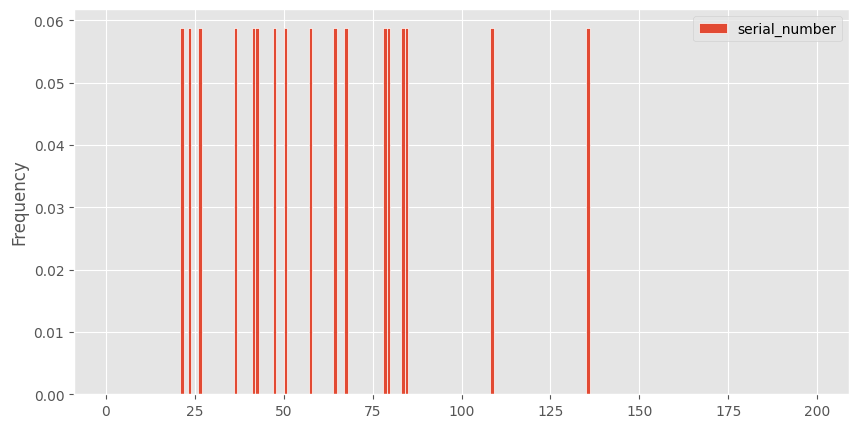

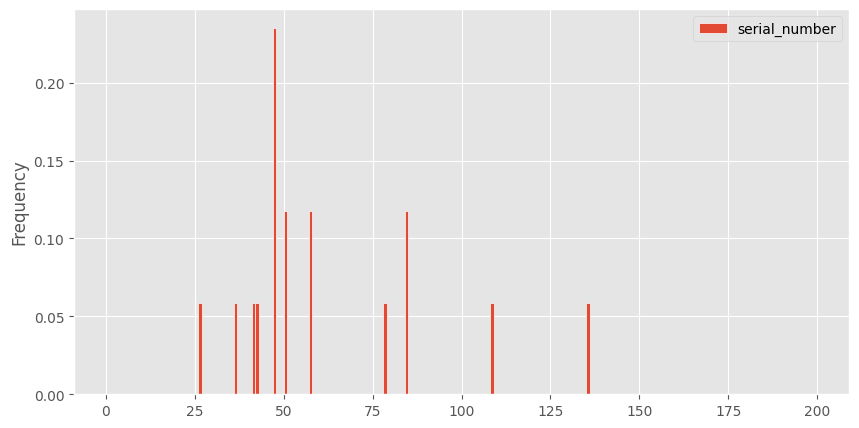

In [39]:
# Histogram of resample.
plot_serial_numbers(one_resample)
plt.show()

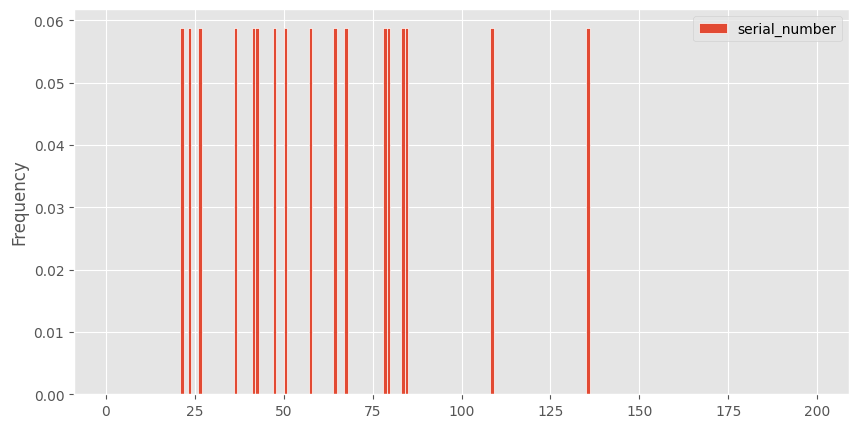

In [40]:
# Histogram of original sample.
plot_serial_numbers(observations)
plt.show()

**Question 3.3.** Which of the following are true:
1. In the plot of the resample, there are no bars at locations that weren't there in the plot of the original observations.
2. In the plot of the original observations, there are no bars at locations that weren't there in the plot of the resample.
3. There are no duplicate serial numbers in the resample.
4. There are no duplicate serial numbers in the original observations.

Assign `true_statements` to a list of the correct statements

In [41]:
true_statements = [1, 4]

**Question 3.4.** Create 2 more resamples. For each resample, plot a histogram and compute the max-based and mean-based estimates using that resample.

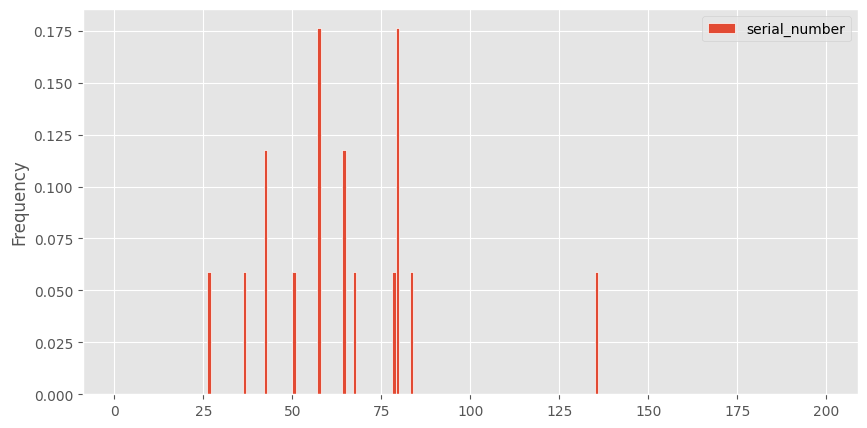

Mean-based estimate for resample 1: 135
Max-based estimate for resample 1: 128.8235294117647




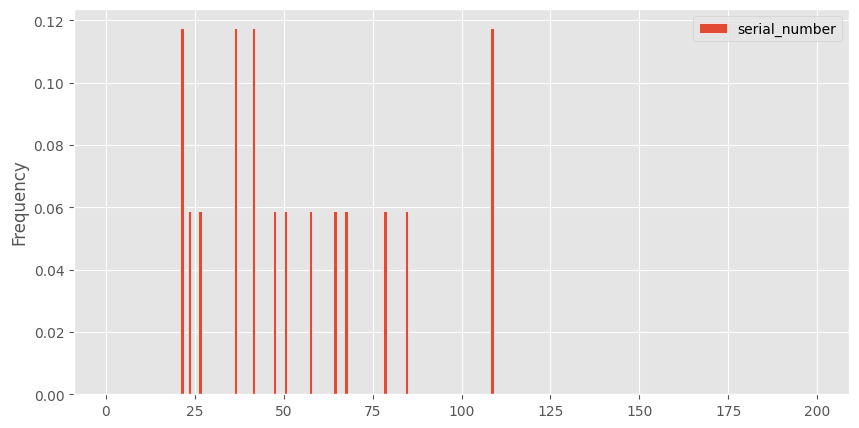

Mean-based estimate for resample 2: 108
Max-based estimate for resample 2: 106.82352941176471




In [42]:
# np.arange(2) because we want to create 2 resamples.
for i in np.arange(2):
    resample = simulate_resample()
    
    # Plot a histogram of this resample.
    plot_serial_numbers(resample)
    plt.show() # Don't change this line!
    
    # Calculate the mean-based and max-based estimates based on this resample.
    mean_based_estimate_resample = calculate_max_based_estimate(resample.get('serial_number'))
    max_based_estimate_resample = calculate_mean_based_estimate(resample.get('serial_number'))
    
    # Don't change the following 3 lines:
    print(f"Mean-based estimate for resample {i+1}:", mean_based_estimate_resample)
    print(f"Max-based estimate for resample {i+1}:", max_based_estimate_resample)
    print('\n')

There's a good chance that you'll find that the max-based estimates from the resamples are both exactly 135 (run the cell a few times and you'll almost surely see this happen). You'll also probably find that the two mean-based estimates differ from the sample mean-based estimate (and from each other).

**Question 3.5.** Compute the exact probability that a max-based estimate from one *resample* of our observations sample is 135 and assign it to the variable `q3_5` below. It may be useful to recall that the size of `observations` is 17.

Note that this is a **math** question, not a programming one. It may help to figure out your answer on paper and then assign `q3_5` to an expression that evaluates to the right answer.

***Hint:*** Think about the "grandma" example from Lecture 11. What is the probability that any one of the elements in our resample is equal to 135?

In [43]:
### I have 17 elements in my sample, and only one is 135. We want:
### P(max_sample = 135) AND P(max_sample != 135) or 1 - P(Both are 135) - P(Both are not 135)
### = 1 - (1/17)**2 - (16/17)**2

### However, it's possible that 135 doesn't even appear in the resamples
### So 1 - P(135 not appearing)
### As we have 17 "spaces" available for 17 different numbers with replacement, that would mean that
### 135 cannot appear in any of the 17 spaces, which is (16/17)**17

In [44]:
q3_5 = 1 - (16/17)**17
q3_5

0.6432138052537073

The correct answer is high, above 60%. Think about why a mean-based estimate from a resample is less likely to be exactly equal to the mean-based estimate from the original sample as compared to a max-based estimate.

## 4. Resampling via Simulation 💻

Since resampling from a large random sample looks just like sampling from a population, the code should look almost the same, too. That means we can write a function that simulates either sampling from a population or resampling from a sample.  If we pass it a population as its argument, it will do the former; if we pass it a sample, it will do the latter.

**Question 4.1.** Complete the implementation of the function `simulate_estimates`. It should take 4 arguments:
- `original_df`: A DataFrame from which the data should be sampled, with a single column named `'serial_number'`.
- `sample_size`: The size of each sample, an integer. (For example, to do resampling, we would pass the number of rows in `original_df` for this argument.)
- `statistic`: A **function** that computes a statistic on a sample. This argument is the **name of a function** that takes a Series of serial numbers as its argument and returns a number (e.g. `calculate_mean_based_estimate`).
- `repetitions`: The number of repetitions to perform (i.e. the number of resamples to create).

It should simulate `repetitions` samples **with replacement** from the given DataFrame. For each of those samples, it should compute the statistic on that sample. Then it should return an array containing the value of that statistic for each sample (this means that the length of the returned array should be equal to `repetitions`).

The code below provides an example use of your function and describes how you can verify that you've written it correctly.

***Check your answer***: The histogram you see should be a roughly bell-shaped curve centered at 1000 with most of its area in the interval [800, 1200].

In [45]:
test_df = bpd.DataFrame().assign(serial_number=np.arange(1, 1000+1))
test_df

,serial_number
0,1
1,2
2,3
3,4
4,5
...,...
995,996
996,997
997,998
998,999


In [46]:
sample_size = 50
test_df.sample(sample_size, replace=True).apply(calculate_mean_based_estimate)

serial_number    1009.56
dtype: float64

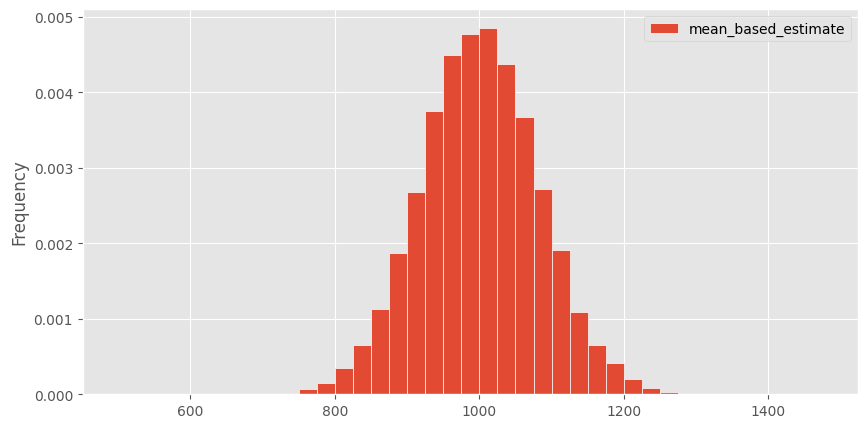

In [47]:
def simulate_estimates(original_df, sample_size, statistic, repetitions):
    # Our implementation of this function took 4 to 5 short lines of code.
    samples = np.array([])
    for i in np.arange(repetitions):
        sampling = original_df.sample(sample_size, replace=True).apply(statistic)
        samples = np.append(samples, sampling)
    return samples
        
        

# This should generate an empirical histogram of twice-mean estimates
# of N from samples of size 50 if N is 1000.
# Notice that the statistic argument is calculate_mean_based_estimate.
example_estimates = simulate_estimates(
    bpd.DataFrame().assign(serial_number=np.arange(1, 1000+1)),
    50,
    calculate_mean_based_estimate,
    10000)
bpd.DataFrame().assign(mean_based_estimate = example_estimates).plot(kind='hist', density=True, bins=np.arange(500, 1500, 25), ec='w');
plt.show()

Now we can go back to the sample we actually observed (`observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

**Question 4.2.** Using the bootstrap procedure and the sample `observations`, simulate the approximate distribution of **mean-based estimates** of `N`. Use 5,000 repetitions. Store the estimates in `bootstrap_estimates`. (Note that this only requires one line of code; call your `simulate_estimates` function.)

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

In [48]:
observations

,serial_number
0,47
1,42
2,57
3,79
4,26
...,...
12,67
13,108
14,84
15,50


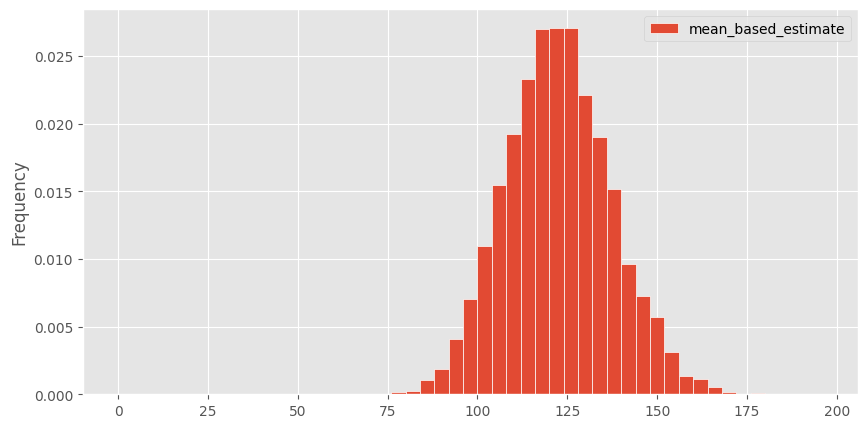

In [49]:
bootstrap_estimates = simulate_estimates(observations, observations.shape[0], calculate_mean_based_estimate, 5000)
bpd.DataFrame().assign(mean_based_estimate=bootstrap_estimates).plot(kind='hist', density=True, bins=np.arange(0, 200, 4), ec='w');
plt.show()

**Question 4.3.** Compute an interval that covers the middle 95% of the bootstrap estimates.  Verify that your interval looks like it covers 95% of the area in the histogram above.


***Hint:*** If you find yourself using 5 and 95 as the arguments to `np.percentile`, try again – only 90% of the data is between the 5th and 95th percentiles!

In [50]:
left_end = np.percentile(bootstrap_estimates, 2.5)
right_end = np.percentile(bootstrap_estimates, 97.5)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end, right_end))

Middle 95% of bootstrap estimates: [94.823529, 152.005882]


**Question 4.4.** Let's say that `N`, the population parameter we've been trying to estimate, is actually 150. Write code that simulates the sampling and bootstrapping process again, as follows:

1. Generate a new set of random observations the Allies might have seen by sampling from the population DataFrame we have created for you below. Take a sample of size 70 **without replacement**. Store the sample in the variable name `new_observations`
2. Using only `new_observations` – not `population` – compute 5,000 bootstrapped mean-based estimates of `N`. To do this, call your  `simulate_estimates` function.
3. Compute an interval covering the middle 95% of these bootstrapped mean-based estimates.

In [51]:
population = bpd.DataFrame().assign(serial_number=np.arange(1, 150+1))
new_observations = population.sample(70, replace=False)
# print(new_observations)
new_bootstrap_estimates = simulate_estimates(new_observations, new_observations.shape[0], calculate_mean_based_estimate, 5000)

new_left_end = np.percentile(new_bootstrap_estimates, 2.5)
new_right_end = np.percentile(new_bootstrap_estimates, 97.5)

print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

Middle 95% of bootstrap estimates: [127.313571, 165.630000]


**Question 4.5.** If you ran your cell above many, many times, approximately what percentage of the intervals you created would include `N` (150 in this case)?  Assign either 1, 2, 3, 4, or 5 to the variable `q4_5` below.

1. 100%
2. 97.5%
3. 95%
4. 5%
5. It's impossible to tell.

In [52]:
q4_5 = 3

## 5. With or Without Replacement? 🔂

Each time we resampled from our original sample, we sampled **with replacement**. What would happen if we tried to resample without replacement? Let's find out!

Below, we will collect another random sample of size 70 from `population` that we can then resample from. We'll call it `original_sample`.

In [53]:
np.random.seed(23) # Magic so that you get the same result as us – don't change this line
original_sample = population.sample(70)
original_sample

,serial_number
139,140
125,126
67,68
3,4
113,114
...,...
53,54
76,77
132,133
114,115


**Question 5.1.** Below, 5,000 times, collect a resample of size 70 **from `original_sample` without replacement**. Compute the mean-based estimate on each resample, and store the estimates in the array `estimates_without_replacement`.

***Note:*** You **cannot** use your `simulate_estimates` function here, because that samples with replacement. Instead, you'll have to write a new for-loop. It's a good idea to start by copying the code from your function in Question 4.1 and changing the necessary pieces.

In [54]:
def simulate_estimates_without_replacement(original_df, sample_size, statistic, repetitions):
    # Our implementation of this function took 4 to 5 short lines of code.
    samples = np.array([])
    for i in np.arange(repetitions):
        sampling = original_df.sample(sample_size, replace=False).apply(statistic)
        samples = np.append(samples, sampling)
    return samples

In [55]:
estimates_without_replacement = simulate_estimates_without_replacement(original_sample, original_sample.shape[0], calculate_mean_based_estimate, 5000)
estimates_without_replacement

array([149.51428571, 149.51428571, 149.51428571, ..., 149.51428571,
       149.51428571, 149.51428571])

**Question 5.2.** If you completed Question 5.1 correctly, you'll notice that all 5,000 of your estimates are identical, and are equal to roughly 149.5143. Furthermore, this number is equal to the mean-based estimate derived from `original_sample`, without any resampling:

In [56]:
calculate_mean_based_estimate(original_sample.get('serial_number'))

149.5142857142857

Why are all of our estimates identical, and why **must** we sample with replacement when resampling?

This happens because, as we are using a sample with the same size as the population, and we are drawing observations without replacement, this means that we will have the same observations every time, which are all values in the `original_sample` dataframe. As such, when we calculate an estimate based on values that are always the same, we will have means that are always the same.

Congratulations! You are done with Lab 4.
